In [1]:
#| label: import

library(ggplot2)

## Solution 1: Evaluating regression learners

### a)

Since the polynomial learner clearly achieves a better fit for the training data and some observations lie rather far from the regression line, which is strongly penalized by $L2$ loss, it will have lower empirical risk than the linear learner.

### b)

First and foremost, evaluation on the training data is almost never a good idea. Under certain conditions the training error does tell us something about generalization ability, but for flexible learners and/or small training data it is deceptive due to optimistic bias. In this particular situation, we have few training observations and quite some points that look a little extreme. A low training error might be achieved by a learner that fits every quirk in the training data but generalizes poorly to unseen points with only slightly different distribution. Evaluation on separate test data is therefore non-negotiable.

### c) 

 We fit the polynomial and linear learner and then compute the squared and absolute differences between their
respective predictions and the true target values:

In [2]:
#| label: 1c

# define train data including outlier
set.seed(123)
x_train <- seq(10, 15, length.out = 50)
y_train <- 10 + 3 * sin(0.15 * pi * x_train) + rnorm(length(x_train), sd = 0.5)
data_train <- data.frame(x = x_train, y = y_train)

# define test data
set.seed(321)
x_test <- seq(10, 15, length.out = 10)
y_test <- 10 + 3 * sin(0.15 * pi * x_test) + rnorm(length(x_test), sd = 0.5)
data_test <- data.frame(x = x_test, y = y_test)

# train learners
polynomial_learner <- lm(y ~ poly(x, 21), data_train)
linear_learner <- lm(y ~ x, data_train)

# predict with both learners
y_polynomial <- predict(polynomial_learner, data_test)
y_lm <- predict(linear_learner, data_test)

# compute errors
abs_differences <- lapply(
  list(y_polynomial, y_lm), 
  function(i) abs(data_test$y - i))
errors_mse <- sapply(abs_differences, function(i) mean(i^2))
errors_mae <- sapply(abs_differences, mean)

print(c(errors_mse, errors_mae))

[1] 0.2731046 0.3031514 0.4140316 0.3827525


The picture is inconclusive: based on MSE, we should prefer the complex polynomial model, while MAE tells us
to pick the linear one. It is important to understand that the choices of inner and outer loss functions encode our
requirements and may have substantial impact on the result. Our learners differ strongly in their complexity:
we have an extremely flexible polynomial and a very robust (though perhaps underfitting) linear one. If, for
example, our test data contains an extreme point far from the remaining observations, the polynomial model
might be able to fit it fairly well, while the LM incurs a large MSE because the distance to this point enters
quadratically. The MAE, on the other hand, is more concerned with small residuals, and there, our LM fares
better. Here, following the MAE assessment would signify preference for a robust model.

However, we must keep in mind that our performance evaluation is based on a single holdout split, which is
not advisable in general and particularly deceptive with so little data. For different test data we quickly get
in situations where the polynomial has both worse MSE and MAE – after all, slapping a learner with 21 + 1
learnable parameters on a 50-points data set should strike you as a rather bad idea.

Take-home message: the choice of our performance metric matters, and making decisions based on a single
train-test split is risky in many data settings.

## Solution 2: Importance of train-test split

### a)

Get the data, define a task and corresponding train-test split, and predict with trained model:

In [3]:
#| label: 2a

# get data
library(mlbench)
data(BostonHousing)
data_pollution <- data.frame(dis = BostonHousing$dis, nox = BostonHousing$nox)
data_pollution <- data_pollution[order(data_pollution$dis), ]
head(data_pollution)

# define task and train-test split
library(mlr3)
task <- mlr3::TaskRegr$new("pollution", backend = data_pollution, target = "nox")
train_set = 1:10
test_set = setdiff(seq_len(task$nrow), train_set)

# train linear learner
library(mlr3learners)
learner <- mlr3::lrn("regr.lm")
learner$train(task, row_ids = train_set)

# predict on test data
predictions <- learner$predict(task, row_ids = test_set)
predictions$score(mlr3::msr("regr.mse"))


,dis,nox
,<dbl>,<dbl>
373,1.1296,0.668
375,1.1370,0.668
372,1.1691,0.631
374,1.1742,0.668
407,1.1781,0.659
371,1.2024,0.631


regr.mse 
1.524512

### b) 

We have chosen the first ten observations from a data set that is ordered by feature value, which is not a good idea because this is not a random sample and covers only a particular area of the feature space. Consequently, we obtain a pretty high test MSE (relatively speaking -- we will see in the next exercise which error values we can usually expect for this task). Looking at the data, this gives us a steeply declining regression line that does not reflect the overall data situation. Also, a training set of ten points is pretty small and will likely lead to poor generalization.

### c)

We repeat the above procedure for different train-test splits like so:


In [4]:
#| label: 2c1
#| output: false

# define train-test splits
repetitions <- 1:10
split_ratios <- seq(0.1, 0.9, by = 0.1)

# create resampling objects with holdout strategy, using lapply for efficient computation
split_strategies <- lapply(split_ratios, function(i) mlr3::rsmp("holdout", ratio = i))

# train linear learners and predict in one step (remember to set a seed)
set.seed(123)
results <- list()
for (i in repetitions) {
  results[[i]] <- lapply(split_strategies, function(i) mlr3::resample(task, learner, i))
}

INFO  [15:20:26.456] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.501] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.528] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.554] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.577] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.600] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.622] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.645] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.675] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.700] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.724] [mlr3] Applying learner 'regr.lm' on task 'pollution' (iter 1/1)
INFO  [15:20:26.748] [mlr3] Applying learner 'regr.lm'

In [5]:
#| label: 2c2
#| output: false

errors <- lapply(
  repetitions,
  function(i) sapply(results[[i]], function(j) j$score()$regr.mse))

# assemble everything in data.frame and convert to long format for plotting
errors_df <- as.data.frame(do.call(cbind, errors))
errors_df$split_ratios <- split_ratios
errors_df_long <- reshape2::melt(errors_df, id.vars = "split_ratios")
names(errors_df_long)[2:3] <- c("repetition", "mse")

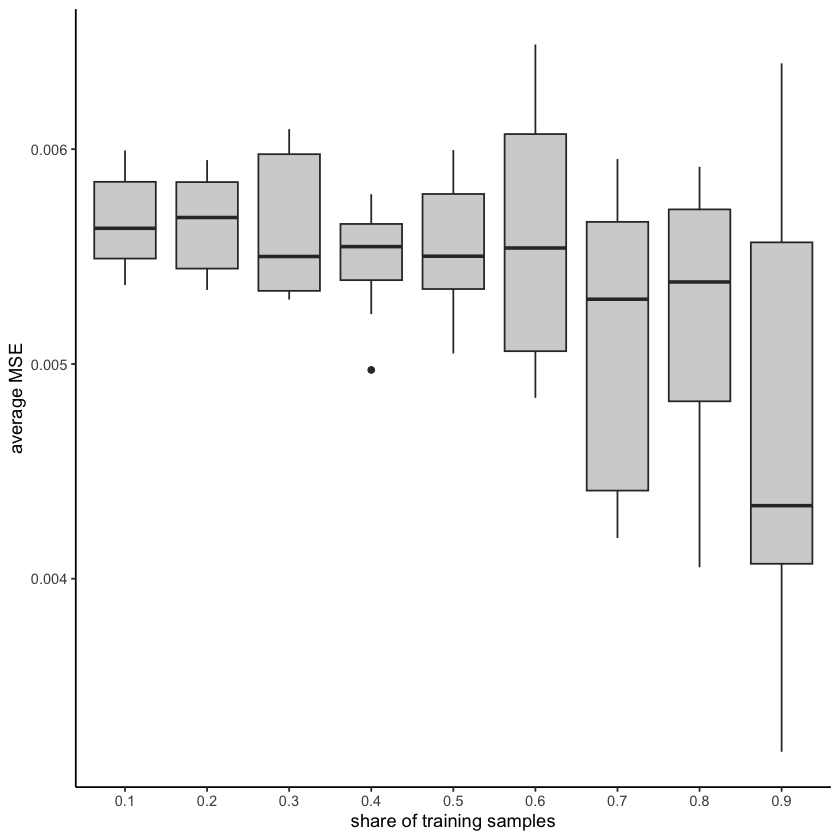

In [6]:
#| label: 2c3

# plot errors vs split ratio
library(ggplot2)
ggplot(errors_df_long, aes(x = as.factor(split_ratios), y = mse)) +
  geom_boxplot(fill = "lightgray") +
  theme_classic() +
  labs(x = "share of training samples", y = "average MSE")